# Applying aPMV setpoints

## Introduction

This notebook demonstrates how to use the `accim` library to implement **Adaptive Predicted Mean Vote (aPMV)** control strategies in EnergyPlus models. 

The aPMV model extends the standard Fanger PMV model by introducing an adaptive coefficient ($\lambda$). This coefficient accounts for the psychological, physiological, and behavioral adaptations of occupants in naturally ventilated or mixed-mode buildings. By dynamically adjusting HVAC setpoints based on aPMV, we can often achieve thermal comfort with lower energy consumption compared to static setpoints.

## Objectives of this Notebook

1.  **Setup:** Load a residential EnergyPlus model and prepare it for simulation.
2.  **Inspect:** Identify the valid control targets (Zones/Spaces) within the model.
3.  **Base Case (PMV):** Simulate the building using standard PMV logic ($\lambda = 0$).
4.  **Adaptive Case (aPMV):** Simulate the building using adaptive logic with custom coefficients for specific zones.
5.  **Compare:** Analyze the differences in setpoints and comfort between the two strategies.

## 1. Setup and Imports

We import the necessary libraries for simulation (`besos`, `accim`) and data analysis (`pandas`, `matplotlib`, `seaborn`).

In [50]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from besos import eppy_funcs as ef
from besos import eplus_funcs as ep

# Import the accim module
import accim.sim.apmv_setpoints as apmv

# Visualization setup
plt.rcParams['figure.figsize'] = [14, 6]
sns.set_style("whitegrid")

# Define file paths
idf_filename = "TestModel_TestResidentialUnit.idf"
epw_filename = 'Seville.epw'

# Check files
if not os.path.exists(idf_filename):
    print(f"⚠️ Warning: {idf_filename} not found.")
else:
    print(f"✅ Model found: {idf_filename}")

✅ Model found: TestModel_TestResidentialUnit.idf


## 2. Loading the Model

We use BESOS to load the IDF file. This creates a building object that we can manipulate in memory.

In [51]:
# Load initial instance for inspection
building = ef.get_building(idf_filename)

Launching 3D geometry viewer...


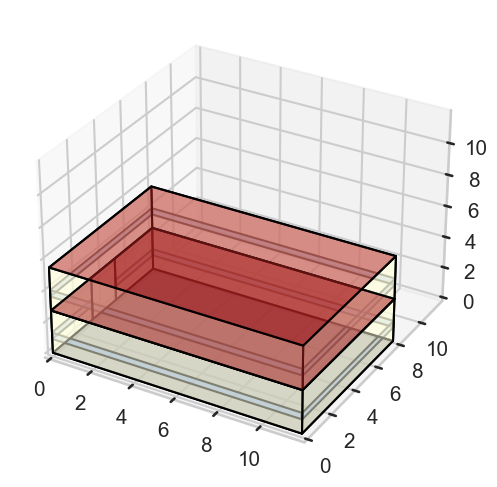

In [52]:
# Let's visulize the idf
from geomeppy import IDF
import os

# 1. Save the current BESOS model to a temporary file
# This ensures geomeppy reads the exact current state of the geometry
temp_idf_name = "temp_geometry_view.idf"
building.saveas(temp_idf_name)
IDF.setiddname("C:\EnergyPlusV25-1-0\Energy+.idd")
# 2. Initialize Geomeppy
# Note: This assumes EnergyPlus is installed and IDD is found automatically
idf_geo = IDF(idf_filename)

# 3. Launch the 3D Viewer
# This will open a separate pop-up window. Check your taskbar if it doesn't appear on top.
print("Launching 3D geometry viewer...")
try:
    idf_geo.view_model()
except Exception as e:
    print(f"Could not open viewer: {e}")

# 4. Cleanup
if os.path.exists(temp_idf_name):
    os.remove(temp_idf_name)

## 3. Model Preparation (Occupancy)

To ensure the adaptive control logic is active and visible throughout the simulation period, we need to ensure the zones are occupied. The `accim` library provides a helper function to force occupancy schedules to 'Always On'.

**Note:** The `apply_apmv_setpoints` function requires the model to have an existing HVAC system (specifically, `ZoneControl:Thermostat` objects) to function correctly. For this demonstration, we assume the loaded IDF already contains a heating/cooling system.

In [53]:
# Set Occupancy to 'Always On' to ensure continuous control
print("--- Setting Occupancy ---")
apmv.set_zones_always_occupied(building=building, verbose_mode=True)

--- Setting Occupancy ---
Added Schedule: On
Updated all People objects to use schedule 'On'.


## 4. Implementing aPMV setpoints

The core function of this module is `apply_apmv_setpoints`. This function injects Energy Management System (EMS) code into the IDF to calculate setpoints dynamically.

### Key Parameters:

*   `adap_coeff_cooling` / `adap_coeff_heating`: The adaptive coefficient ($\lambda$).
    *   If $\lambda = 0$, the logic mimics standard Fanger PMV.
    *   If $\lambda > 0$, the logic applies adaptive comfort (usually widening the comfort band).
    *   Can be a single `float` (global) or a `dict` (per zone).
*   `pmv_cooling_sp` / `pmv_heating_sp`: The target PMV index (e.g., +0.5 for cooling, -0.5 for heating).
*   `tolerance_...`: Additional deadbands applied to the calculated setpoint.
    *   **Default value:** `0.1`.
    *   **How it works:** The tolerance tightens the setpoint range to create a safety margin. For example, if you specify a `pmv_cooling_sp` of **0.5**, the effective setpoint used in the simulation will be **0.4** ($0.5 - 0.1$). Similarly, for a `pmv_heating_sp` of **-0.5**, the effective setpoint becomes **-0.4** ($-0.5 + 0.1$).
    *   **Purpose:** This ensures that all simulation hours remain strictly within the desired limits, preventing situations where setpoints are exceeded by small fractions (tenths or hundredths).

### Inspecting Targets

Before applying the logic, we must know **where** to apply it. The function `get_available_target_names` scans the model for People objects and returns the valid keys (Zone or Space names) to use in our configuration.

In [54]:
# Identify valid targets in the model
target_names = apmv.get_available_target_names(building=building)

print(f"Found {len(target_names)} targets:")
for t in target_names:
    print(f" - {t}")

Found 2 targets:
 - Floor_1 Residential Living Occupants
 - Floor_2 Residential Living Occupants


### Generating an Input Template

Most parameters in `accim` (such as adaptive coefficients $\lambda$, setpoints, or tolerances) can be configured **independently for each zone**.

To do this, instead of passing a single number (which applies globally), you pass a **dictionary** following the pattern `{'Target Name': value}`.

If you are unsure of the exact keys to use, the function `get_input_template_dictionary` generates a blank dictionary containing all valid target keys found in your model.

In [55]:
# Generate a template dictionary
template = apmv.get_input_template_dictionary(building=building)

print("Template dictionary structure:")
print(template)

Template dictionary structure:
{'Floor_1 Residential Living Occupants': 'replace-me-with-float-value', 'Floor_2 Residential Living Occupants': 'replace-me-with-float-value'}


### 4.1 Base case

#### 4.1.1 Implementing PMV setpoints

In this section, we generate the **Base Case**. We will use the `apply_apmv_setpoints` function, but we will set the adaptive coefficients (`adap_coeff_cooling` and `adap_coeff_heating`) to **0**.

Mathematically, if $\lambda = 0$, then $aPMV = PMV$. This effectively simulates a standard Fanger PMV control strategy.

In [56]:
# 1. Reload model to ensure a clean state
building_base = ef.get_building(idf_filename)
apmv.set_zones_always_occupied(building_base, verbose_mode=False)

In [57]:
# 2. Apply PMV logic (Lambda = 0)
print("Applying Base Case (PMV) logic...")
building_base = apmv.apply_apmv_setpoints(
    building=building_base,
    adap_coeff_cooling=0,  # Zero means standard PMV
    adap_coeff_heating=0,  # Zero means standard PMV
    pmv_cooling_sp=0.5,
    pmv_heating_sp=-0.5,
    cooling_season_start='01/05',
    cooling_season_end='30/09',
    verbose_mode=False
)

Applying Base Case (PMV) logic...


#### 4.1.2 PMV setpoints simulation

We run the simulation for the base case and store the results.

In [58]:
out_dir_base = 'sim_results_base'
print(f"Running Base Case simulation in {out_dir_base}...")

ep.run_building(
    building=building_base,
    out_dir=out_dir_base,
    epw=epw_filename
)
print("Base simulation finished.")

Running Base Case simulation in sim_results_base...
Running EnergyPlus with stdout output suppressed...
Base simulation finished.


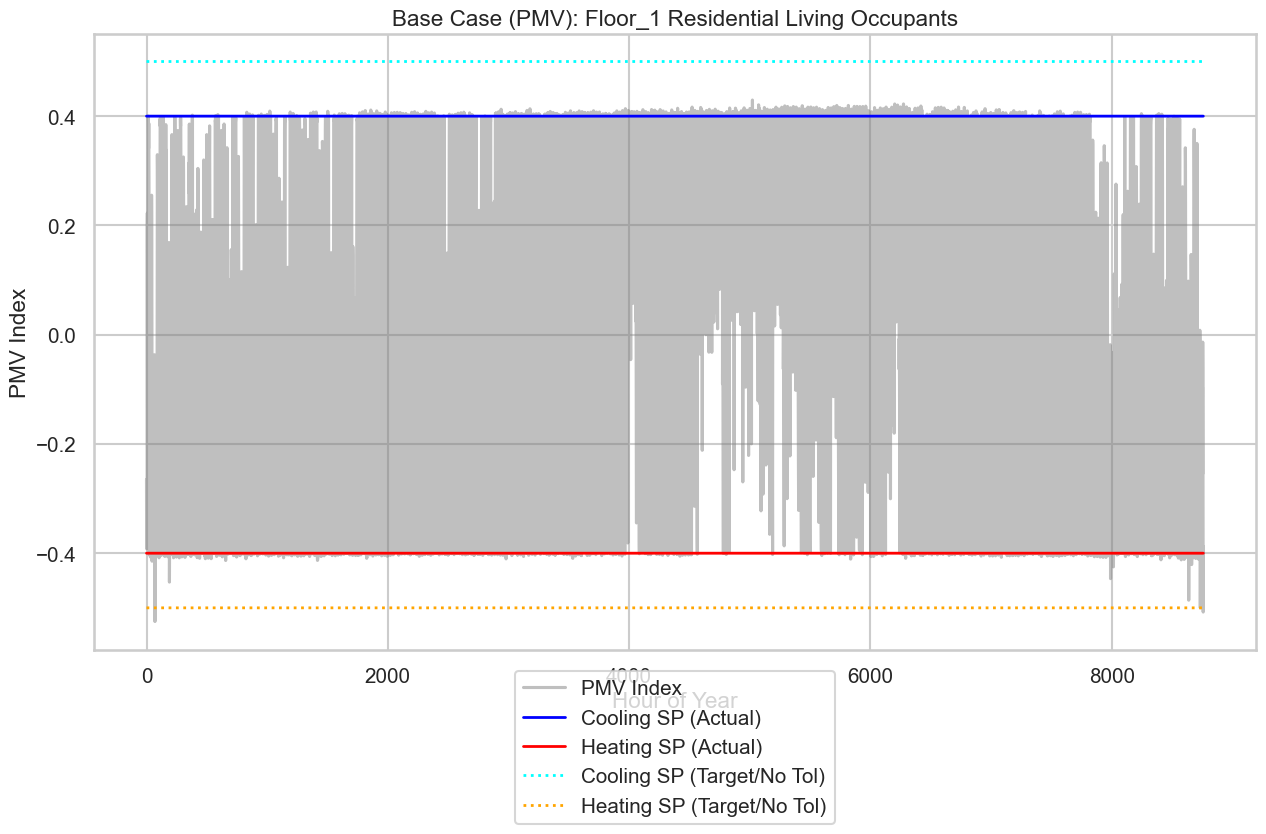

In [59]:
# Load Base Results
df_base = pd.read_csv(os.path.join(out_dir_base, 'eplusout.csv'))
df_base['Hour'] = df_base.index

# Visualize Zone 1 (Example)
target_zone = target_names[0].replace(" ", "_").replace(":", "_") # Sanitize name for column search

plt.figure(figsize=(15, 8))

# Filter for summer period (approx hours 3600 to 4300)
# start_h = 3600
# end_h = 4300
# subset = df_base.iloc[start_h:end_h]
subset = df_base

try:
    # 1. Identify Columns
    # Actual PMV Value
    col_pmv = [c for c in df_base.columns if 'EMS:aPMV' in c and target_zone in c and 'Setpoint' not in c][0]

    # Actual Setpoints (With Tolerance applied)
    col_cool = [c for c in df_base.columns if 'EMS:aPMV Cooling Setpoint' in c and target_zone in c and 'No Tolerance' not in c][0]
    col_heat = [c for c in df_base.columns if 'EMS:aPMV Heating Setpoint' in c and target_zone in c and 'No Tolerance' not in c][0]

    # Target Setpoints (No Tolerance - The theoretical limit)
    col_cool_no_tol = [c for c in df_base.columns if 'EMS:aPMV Cooling Setpoint No Tolerance' in c and target_zone in c][0]
    col_heat_no_tol = [c for c in df_base.columns if 'EMS:aPMV Heating Setpoint No Tolerance' in c and target_zone in c][0]

    # 2. Plotting
    # Plot PMV Index
    sns.lineplot(x=subset.index, y=subset[col_pmv], label='PMV Index', color='gray', alpha=0.5)

    # Plot Actual Setpoints (Solid lines)
    sns.lineplot(x=subset.index, y=subset[col_cool], label='Cooling SP (Actual)', color='blue', linewidth=2)
    sns.lineplot(x=subset.index, y=subset[col_heat], label='Heating SP (Actual)', color='red', linewidth=2)

    # Plot Theoretical Setpoints (Dotted lines)
    sns.lineplot(x=subset.index, y=subset[col_cool_no_tol], label='Cooling SP (Target/No Tol)', color='cyan', linestyle=':', linewidth=2)
    sns.lineplot(x=subset.index, y=subset[col_heat_no_tol], label='Heating SP (Target/No Tol)', color='orange', linestyle=':', linewidth=2)

    plt.title(f"Base Case (PMV): {target_names[0]}")
    plt.ylabel("PMV Index")
    plt.xlabel("Hour of Year")
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3))
    plt.show()
    plt.show()

except IndexError:
    print("Could not find output columns. Check simulation results.")

### 4.2 aPMV setpoints implemented case

#### 4.2.1 Implementing aPMV setpoints

Now we generate the **Adaptive Case**. We will define specific adaptive coefficients for our zones.

*   **Floor_1 Residential Living Occupants:** High adaptation ($\lambda = 0.4$).
*   **Floor_2 Residential Living Occupants:** Low adaptation ($\lambda = 0.1$).

In [60]:
# 1. Reload model fresh
building_apmv = ef.get_building(idf_filename)
apmv.set_zones_always_occupied(building_apmv, verbose_mode=False)

In [61]:
custom_coeffs = apmv.get_input_template_dictionary(building=building_apmv)
print(custom_coeffs)

{'Floor_1 Residential Living Occupants': 'replace-me-with-float-value', 'Floor_2 Residential Living Occupants': 'replace-me-with-float-value'}


In [62]:
for k, v in custom_coeffs.items():
    if 'Floor_1 Residential Living Occupants' == k:
        custom_coeffs[k] = 0.4
    elif 'Floor_2 Residential Living Occupants' == k:
        custom_coeffs[k] = 0.1

print(custom_coeffs)

{'Floor_1 Residential Living Occupants': 0.4, 'Floor_2 Residential Living Occupants': 0.1}


In [63]:
apmv.set_pmv_input_parameters(
    building=building_apmv,
    activity_level=100,
    # clothing_insulation=0.75,
    air_velocity=0.1,
    work_efficiency=0.0
)

Set Activity for 'Residential Living Occupants': 100 W/person
Set Air Velocity for 'Residential Living Occupants': 0.1 m/s
Set Work Efficiency for 'Residential Living Occupants': 0.0


In [64]:
# 3. Apply aPMV logic
print("Applying Adaptive Case (aPMV) logic...")
building_apmv = apmv.apply_apmv_setpoints(
    building=building_apmv,
    adap_coeff_cooling=custom_coeffs,
    adap_coeff_heating=-0.1, # Global value for heating
    pmv_cooling_sp=0.5,
    pmv_heating_sp=-0.5,
    cooling_season_start='01/05',
    cooling_season_end='30/09',
    verbose_mode=False,
    outputs_freq=['hourly']
)

Applying Adaptive Case (aPMV) logic...


In [65]:
# Verify the EMS Program generation
# We search for the 'apply_aPMV' program corresponding to the first target zone to inspect the logic

# 1. Construct the expected program name (accim sanitizes spaces to underscores)
target_sanitized = target_names[0].replace(" ", "_").replace(":", "_")
prog_name_search = f"apply_aPMV_{target_sanitized}"

# 2. Find the object in the IDF
programs = [p for p in building_apmv.idfobjects['EnergyManagementSystem:Program'] if prog_name_search in p.Name]

# 3. Display the result
if programs:
    print(f"--- EMS Program found for {target_names[0]} ---")
    print(programs[0])
else:
    print(f"EMS Program '{prog_name_search}' not found.")

--- EMS Program found for Floor_1 Residential Living Occupants ---

ENERGYMANAGEMENTSYSTEM:PROGRAM,
    apply_aPMV_Floor_1_Residential_Living_Occupants,    !- Name
    if CoolingSeason == 1,    !- Program Line 1
    set adap_coeff_Floor_1_Residential_Living_Occupants = adap_coeff_cooling_Floor_1_Residential_Living_Occupants,    !- Program Line 2
    set tolerance_cooling_sp_Floor_1_Residential_Living_Occupants = tolerance_cooling_sp_cooling_season_Floor_1_Residential_Living_Occupants,    !- Program Line 3
    set tolerance_heating_sp_Floor_1_Residential_Living_Occupants = tolerance_heating_sp_cooling_season_Floor_1_Residential_Living_Occupants,    !- Program Line 4
    elseif CoolingSeason == 0,    !- Program Line 5
    set adap_coeff_Floor_1_Residential_Living_Occupants = adap_coeff_heating_Floor_1_Residential_Living_Occupants,    !- Program Line 6
    set tolerance_cooling_sp_Floor_1_Residential_Living_Occupants = tolerance_cooling_sp_heating_season_Floor_1_Residential_Living_Occupan

#### 4.2.2 aPMV setpoints simulation

We run the simulation for the adaptive case.

In [66]:
out_dir_apmv = 'sim_results_apmv'
print(f"Running Adaptive Case simulation in {out_dir_apmv}...")

ep.run_building(
    building=building_apmv,
    out_dir=out_dir_apmv,
    epw=epw_filename
)
print("Adaptive simulation finished.")

Running Adaptive Case simulation in sim_results_apmv...
Running EnergyPlus with stdout output suppressed...
Adaptive simulation finished.


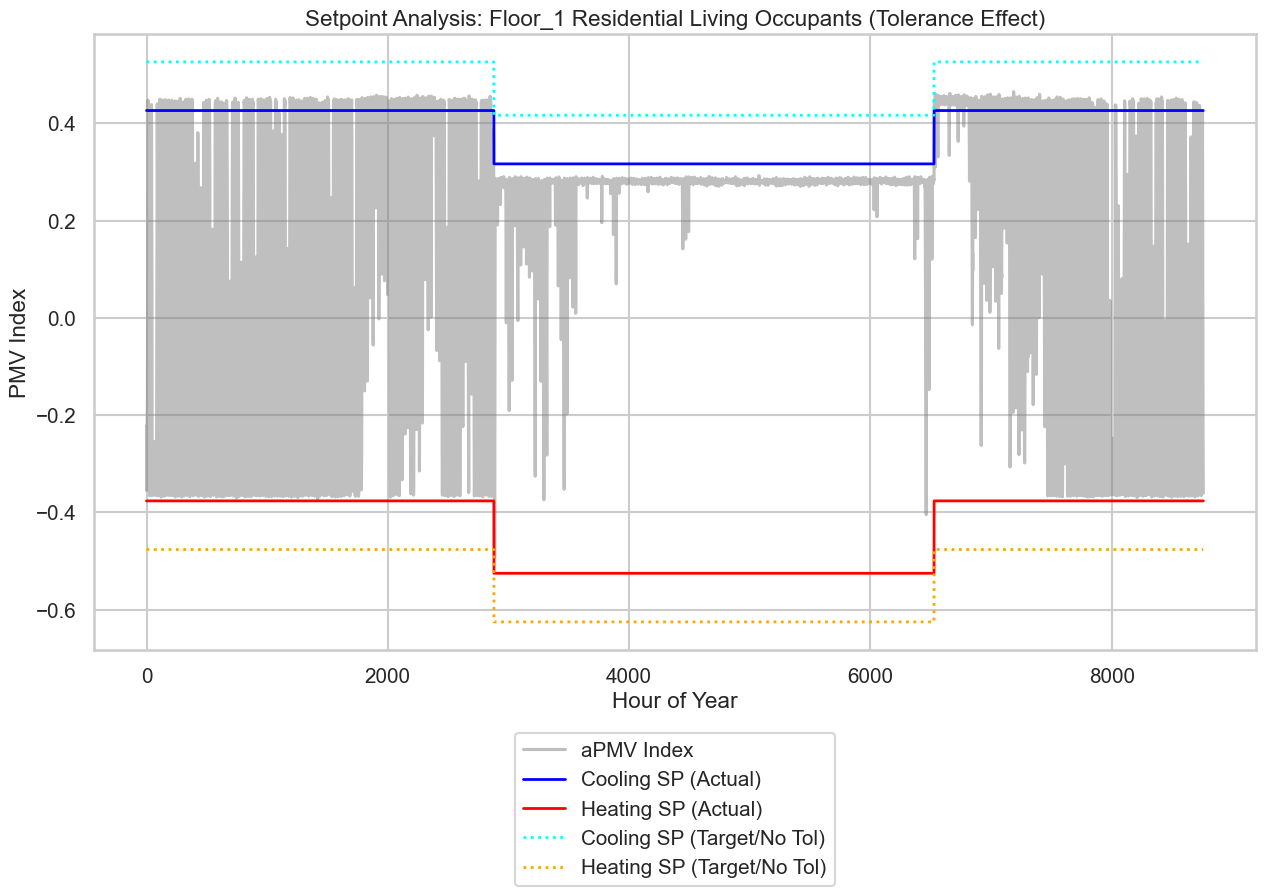

In [67]:
# Load aPMV Results
df_apmv = pd.read_csv(os.path.join(out_dir_apmv, 'eplusout.csv'))
df_apmv['Hour'] = df_apmv.index

# Visualize Zone 1 (Example)
target_zone = target_names[0].replace(" ", "_").replace(":", "_") # Sanitize name for column search
plt.figure(figsize=(15, 8))

# Filter for summer period (approx hours 3600 to 4300)
# start_h = 3600
# end_h = 4300
# subset = df_apmv.iloc[start_h:end_h]
subset = df_apmv


try:
    # 1. Identify Columns
    # Actual aPMV Value
    col_apmv = [c for c in df_apmv.columns if 'EMS:aPMV' in c and target_zone in c and 'Setpoint' not in c][0]
    # Actual Setpoints (With Tolerance applied)
    col_cool = [c for c in df_apmv.columns if 'EMS:aPMV Cooling Setpoint' in c and target_zone in c and 'No Tolerance' not in c][0]
    col_heat = [c for c in df_apmv.columns if 'EMS:aPMV Heating Setpoint' in c and target_zone in c and 'No Tolerance' not in c][0]

    # Target Setpoints (No Tolerance - The theoretical limit)
    col_cool_no_tol = [c for c in df_apmv.columns if 'EMS:aPMV Cooling Setpoint No Tolerance' in c and target_zone in c][0]
    col_heat_no_tol = [c for c in df_apmv.columns if 'EMS:aPMV Heating Setpoint No Tolerance' in c and target_zone in c][0]

    # 2. Plotting
    # Plot PMV Index
    sns.lineplot(x=subset.index, y=subset[col_apmv], label='aPMV Index', color='gray', alpha=0.5)
    # Plot Actual Setpoints (Solid lines)
    sns.lineplot(x=subset.index, y=subset[col_cool], label='Cooling SP (Actual)', color='blue', linewidth=2)
    sns.lineplot(x=subset.index, y=subset[col_heat], label='Heating SP (Actual)', color='red', linewidth=2)

    # Plot Theoretical Setpoints (Dotted lines)
    sns.lineplot(x=subset.index, y=subset[col_cool_no_tol], label='Cooling SP (Target/No Tol)', color='cyan', linestyle=':', linewidth=2)
    sns.lineplot(x=subset.index, y=subset[col_heat_no_tol], label='Heating SP (Target/No Tol)', color='orange', linestyle=':', linewidth=2)

    plt.title(f"Setpoint Analysis: {target_names[0]} (Tolerance Effect)")
    plt.ylabel("PMV Index")
    plt.xlabel("Hour of Year")
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.4))
    plt.show()

except IndexError:
    print("Error: Could not find matching columns for comparison.")

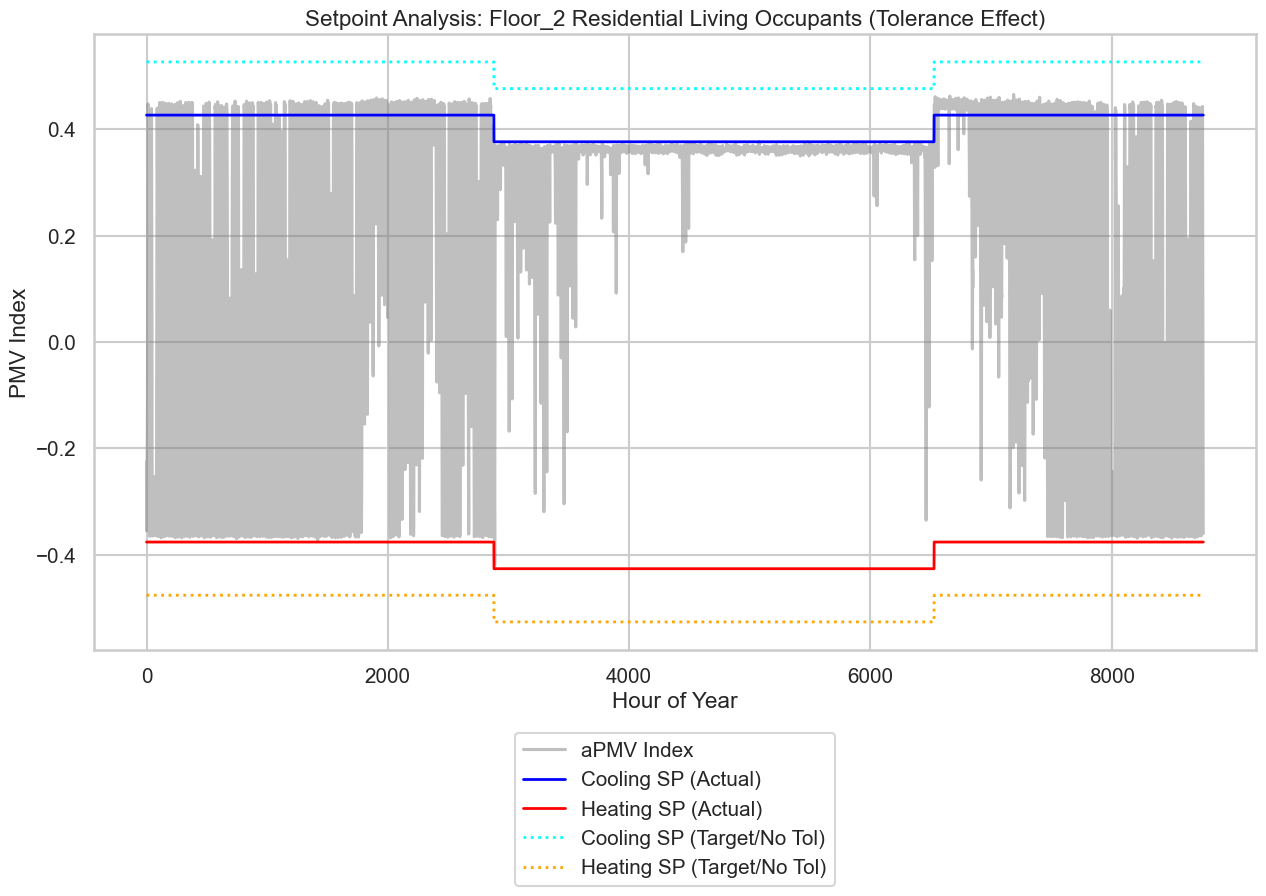

In [68]:
# Load aPMV Results
df_apmv = pd.read_csv(os.path.join(out_dir_apmv, 'eplusout.csv'))
df_apmv['Hour'] = df_apmv.index

# Visualize Zone 1 (Example)
target_zone = target_names[1].replace(" ", "_").replace(":", "_") # Sanitize name for column search
plt.figure(figsize=(15, 8))

# Filter for summer period (approx hours 3600 to 4300)
# start_h = 3600
# end_h = 4300
# subset = df_apmv.iloc[start_h:end_h]
subset = df_apmv


try:
    # 1. Identify Columns
    # Actual aPMV Value
    col_apmv = [c for c in df_apmv.columns if 'EMS:aPMV' in c and target_zone in c and 'Setpoint' not in c][0]
    # Actual Setpoints (With Tolerance applied)
    col_cool = [c for c in df_apmv.columns if 'EMS:aPMV Cooling Setpoint' in c and target_zone in c and 'No Tolerance' not in c][0]
    col_heat = [c for c in df_apmv.columns if 'EMS:aPMV Heating Setpoint' in c and target_zone in c and 'No Tolerance' not in c][0]

    # Target Setpoints (No Tolerance - The theoretical limit)
    col_cool_no_tol = [c for c in df_apmv.columns if 'EMS:aPMV Cooling Setpoint No Tolerance' in c and target_zone in c][0]
    col_heat_no_tol = [c for c in df_apmv.columns if 'EMS:aPMV Heating Setpoint No Tolerance' in c and target_zone in c][0]

    # 2. Plotting
    # Plot PMV Index
    sns.lineplot(x=subset.index, y=subset[col_apmv], label='aPMV Index', color='gray', alpha=0.5)
    # Plot Actual Setpoints (Solid lines)
    sns.lineplot(x=subset.index, y=subset[col_cool], label='Cooling SP (Actual)', color='blue', linewidth=2)
    sns.lineplot(x=subset.index, y=subset[col_heat], label='Heating SP (Actual)', color='red', linewidth=2)

    # Plot Theoretical Setpoints (Dotted lines)
    sns.lineplot(x=subset.index, y=subset[col_cool_no_tol], label='Cooling SP (Target/No Tol)', color='cyan', linestyle=':', linewidth=2)
    sns.lineplot(x=subset.index, y=subset[col_heat_no_tol], label='Heating SP (Target/No Tol)', color='orange', linestyle=':', linewidth=2)

    plt.title(f"Setpoint Analysis: {target_names[1]} (Tolerance Effect)")
    plt.ylabel("PMV Index")
    plt.xlabel("Hour of Year")
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.4))
    plt.show()

except IndexError:
    print("Error: Could not find matching columns for comparison.")

## 5. Results Comparison: Comfort vs. Energy

In this final section, we visualize the relationship between the thermal comfort index and energy consumption for both simulations.

We generate a **Joint Plot** that combines:
1.  **Scatter Plot:** Compares the Comfort Index (PMV for the Base Case, aPMV for the Adaptive Case) against the HVAC Energy Consumption.
2.  **Distributions:** Histograms on the margins showing the density of data points.
3.  **Setpoint Lines:** Vertical lines indicating the theoretical limits for both models.

**Note:** The vertical lines for the **aPMV setpoints** are calculated using $\lambda = 0.4$, which corresponds to the configuration used for **Zone 1** in this tutorial. You can observe how the adaptive model shifts the effective setpoints, widening the comfort zone.

Plotting: EMS:aPMV_Floor_1_Residential_Living_Occupants vs Electricity:HVAC


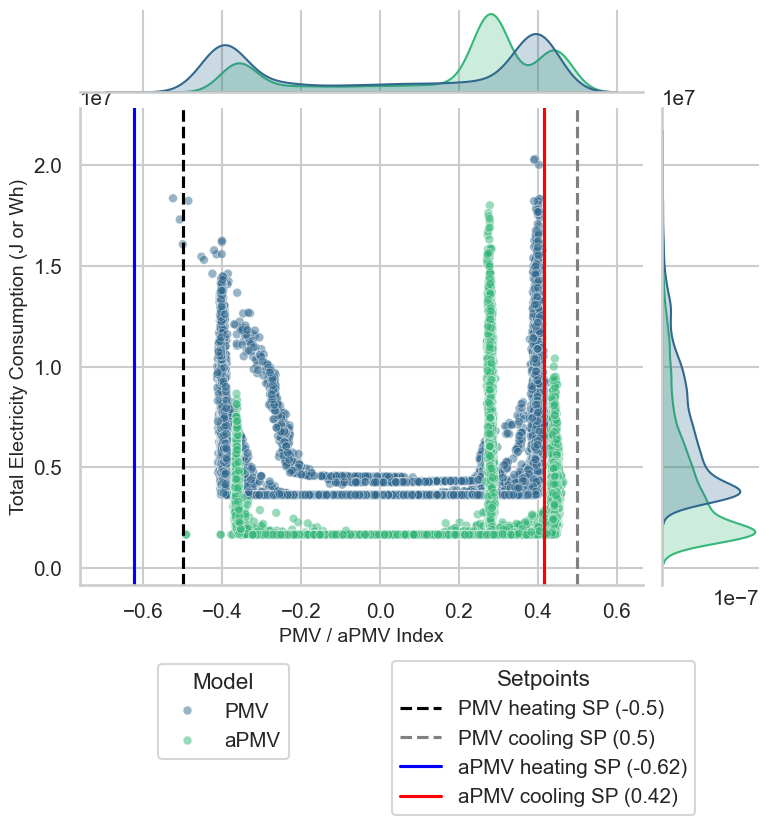

In [69]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings # Importamos la librería de warnings

# --- SILENCIAR WARNINGS ---
# Esto evita que aparezcan los mensajes de incompatibilidad entre pandas/seaborn
warnings.simplefilter(action='ignore', category=FutureWarning)

# =============================================================================
# 1. DATA LOADING AND PREPARATION
# =============================================================================

# Define paths to the results generated in previous steps
path_pmv = os.path.join('sim_results_base', 'eplusout.csv')
path_apmv = os.path.join('sim_results_apmv', 'eplusout.csv')

try:
    # Load DataFrames
    df_pmv = pd.read_csv(path_pmv)
    df_pmv['Source'] = 'PMV'

    df_apmv = pd.read_csv(path_apmv)
    df_apmv['Source'] = 'aPMV'

    # Concatenate
    df = pd.concat([df_pmv, df_apmv], ignore_index=True)

    # Clean column names (remove units and brackets)
    df.columns = df.columns.str.replace(r'\s*\[.*?\]\(Hourly\)?', '', regex=True)
    df.columns = df.columns.str.strip()

    # --- Dynamic Column Identification ---
    # 1. aPMV Column: We use the first zone identified in the notebook
    # We sanitize the name just like EMS does (spaces -> underscores)
    target_zone_sanitized = target_names[0].replace(" ", "_").replace(":", "_")

    # Search for the column containing 'EMS:aPMV' and the zone name
    apmv_cols = [c for c in df.columns if 'EMS:aPMV' in c and target_zone_sanitized in c and 'Setpoint' not in c]
    if not apmv_cols:
        raise KeyError(f"aPMV column not found for {target_zone_sanitized}")
    apmv_col = apmv_cols[0]

    # 2. Energy Column: Search for 'Electricity:Facility' or similar
    # Note: The original script divided by area. Here we show total consumption.
    elec_cols = [c for c in df.columns if 'Electricity:HVAC' in c]
    if elec_cols:
        hvac_col = elec_cols[0]
        df['HVAC Consumption'] = df[hvac_col]
        y_label = 'Total Electricity Consumption (J or Wh)'
    else:
        raise KeyError("Electricity column (Electricity:Facility) not found")

    print(f"Plotting: {apmv_col} vs {hvac_col}")

except FileNotFoundError:
    print("⚠️ Error: Result files not found. Ensure you have run the simulations (Steps 4.1.2 and 4.2.2).")
except KeyError as e:
    print(f"⚠️ Data Error: {e}")

else:
    # =============================================================================
    # 2. FIGURE GENERATION
    # =============================================================================

    # Style configuration
    sns.set_theme(style="whitegrid")
    sns.set_context("talk", font_scale=0.9)

    # Create the jointplot
    g2 = sns.jointplot(
        data=df,
        x=apmv_col,
        y='HVAC Consumption',
        hue='Source',
        palette='viridis',
        height=8,
        joint_kws={'alpha': 0.5, 's': 40},
        marginal_kws={'fill': True, 'common_norm': False}
    )

    ax2 = g2.ax_joint

    # --- Calculate Theoretical Setpoints for lines ---
    # Base PMV: -0.5 and 0.5
    # Adaptive aPMV: Calculated with Lambda = 0.4 (used in the tutorial for Zone 1)
    # Formula: SP_aPMV = SP_PMV / (1 + lambda * SP_PMV)
    lambda_val = 0.4
    apmv_cool_sp = 0.5 / (1 + lambda_val * 0.5)   # approx 0.416
    apmv_heat_sp = -0.5 / (1 + lambda_val * -0.5) # approx -0.625

    # Add vertical lines
    ax2.axvline(x=-0.5, linestyle="--", color="black", label='PMV heating SP (-0.5)')
    ax2.axvline(x=0.5, linestyle="--", color="grey", label='PMV cooling SP (0.5)')
    ax2.axvline(x=apmv_heat_sp, linestyle="-", color="blue", label=f'aPMV heating SP ({apmv_heat_sp:.2f})')
    ax2.axvline(x=apmv_cool_sp, linestyle="-", color="red", label=f'aPMV cooling SP ({apmv_cool_sp:.2f})')

    # Labels
    g2.set_axis_labels('PMV / aPMV Index', y_label, fontsize=14)

    # --- CUSTOM LEGENDS ---
    handles, labels = ax2.get_legend_handles_labels()
    if ax2.get_legend(): ax2.get_legend().remove()
    g2.fig.subplots_adjust(bottom=0.25)

    # Separate handles (Scatter vs Lines)
    # The first N handles belong to the scatter (Source), the rest are the lines
    n_sources = len(df['Source'].unique())

    g2.fig.legend(handles[:n_sources], labels[:n_sources], loc='lower center', bbox_to_anchor=(0.3, 0.02), title='Model')
    g2.fig.legend(handles[n_sources:], labels[n_sources:], loc='lower center', bbox_to_anchor=(0.7, -0.05), title='Setpoints')

    plt.show()

## 6. Conclusion

This notebook demonstrated the implementation of the `accim`'s module `apmv_setpoints` to apply adaptive comfort control.

1.  We successfully identified control targets using `get_available_target_names`.
2.  We simulated a **Base Case** where $\lambda=0$, resulting in static PMV setpoints.
3.  We simulated an **Adaptive Case** where $\lambda=0.4$ for Space 1 and $\lambda=0.1$ for Space 2, resulting in dynamic setpoints that relax the cooling requirements during warm periods.
4.  The comparison shows that the aPMV logic effectively adapts the comfort band, which typically leads to significant energy savings while maintaining occupant satisfaction according to the aPMV model.

## 7. Cleanup

Finally, we remove the simulation output directories to clean up the workspace. **Warning:** This will permanently delete the simulation results generated in this notebook.

In [70]:
import shutil, os

# Define directories to remove
dirs_to_remove = ['sim_results_base', 'sim_results_apmv']

print("Cleaning up generated files...")
for d in dirs_to_remove:
    if os.path.exists(d):
        try:
            shutil.rmtree(d)
            print(f"✅ Removed directory: {d}")
        except OSError as e:
            print(f"❌ Error removing {d}: {e}")
    else:
        print(f"⚠️ Directory {d} not found.")

print("Cleanup complete.")

Cleaning up generated files...
✅ Removed directory: sim_results_base
✅ Removed directory: sim_results_apmv
Cleanup complete.
